In [1]:
#!pip install pandas numpy os matplotlib xgboost scikit-learn seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timedelta
import re
import matplotlib.cm as cm
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
warnings.filterwarnings("ignore")

## Data Loading

In [3]:
data = pd.read_excel("timeseries_data.xlsx")
print(f"Successfully loaded data with {len(data)} rows")

Successfully loaded data with 355 rows


In [4]:
data.head(10)

,ID,WEEK_END_DT,TOTAL_DISPENSED,FLAVORED_DISPENSED
0,743BD6E,2022-07-10,278418.0,60878.00000
1,1CD19D3,2022-07-10,28045.0,10517.00004
2,D3635AD,2022-07-10,23631.0,16203.99998
3,A74A256,2022-07-10,NaN,NaN
4,BB7EA2A,2022-07-10,132980.0,79995.00001
5,743BD6E,2022-07-17,427586.0,102831.00000
6,1CD19D3,2022-07-17,34723.0,12025.99998
7,D3635AD,2022-07-17,71300.0,50330.00007
8,A74A256,2022-07-17,NaN,NaN
9,BB7EA2A,2022-07-17,191913.0,111138.00024


## Data Handling

### 1. Data Validation

In [5]:
def validate_water_dispenser_data(df):
    """
    Validates water dispenser data.
    """
    
    # Check ID 
    # Look for null IDs
    null_ids = df['ID'].isnull().sum()
    if null_ids > 0:
        print(f"ERROR: {null_ids} null IDs found")

    # Check for duplicate IDs in same week
    duplicate_records = df[df.duplicated(subset=['ID', 'WEEK_END_DT'], keep=False)]
    if not duplicate_records.empty:
        print(f"ERROR: {len(duplicate_records)} duplicate ID-Week combos")

    # Check WEEK_END_DT
    # Try converting to datetime
    try:
        df['WEEK_END_DT'] = pd.to_datetime(df['WEEK_END_DT'])
    except Exception as e:
        invalid_dates = df[~pd.to_datetime(df['WEEK_END_DT'], errors='coerce').notna()]['WEEK_END_DT'].tolist()
        print(f"ERROR: {len(invalid_dates)} bad date formats: {invalid_dates[:5]}...")

    # Make sure week end dates are Sundays
    if 'WEEK_END_DT' in df.columns and pd.api.types.is_datetime64_any_dtype(df['WEEK_END_DT']):
        non_sunday_dates = df[df['WEEK_END_DT'].dt.dayofweek != 6]['WEEK_END_DT'].tolist()
        if non_sunday_dates:
            print(f"ERROR: {len(non_sunday_dates)} non-Sunday week end dates: {non_sunday_dates[:5]}...")

    # Check TOTAL_DISPENSED
    # Look for non-numeric 
    non_numeric_totals = df[~pd.to_numeric(df['TOTAL_DISPENSED'], errors='coerce').notna()]['TOTAL_DISPENSED'].tolist()
    if non_numeric_totals:
        print(f"ERROR: {len(non_numeric_totals)} non-numeric TOTAL_DISPENSED values: {non_numeric_totals[:5]}...")

    # Check for negative values
    negative_totals = df[df['TOTAL_DISPENSED'] < 0]['TOTAL_DISPENSED'].tolist()
    if negative_totals:
        print(f"ERROR: {len(negative_totals)} negative TOTAL_DISPENSED values: {negative_totals[:5]}...")

    # Check FLAVORED_DISPENSED
    # Look for non-numeric 
    non_numeric_flavored = df[~pd.to_numeric(df['FLAVORED_DISPENSED'], errors='coerce').notna()]['FLAVORED_DISPENSED'].tolist()
    if non_numeric_flavored:
        print(f"ERROR: {len(non_numeric_flavored)} non-numeric FLAVORED_DISPENSED values: {non_numeric_flavored[:5]}...")

    # Check for negative values
    negative_flavored = df[df['FLAVORED_DISPENSED'] < 0]['FLAVORED_DISPENSED'].tolist()
    if negative_flavored:
        print(f"ERROR: {len(negative_flavored)} negative FLAVORED_DISPENSED values: {negative_flavored[:5]}...")

    # Make sure FLAVORED_DISPENSED <= TOTAL_DISPENSED
    invalid_flavor_ratio = df[df['FLAVORED_DISPENSED'] > df['TOTAL_DISPENSED']][['ID', 'WEEK_END_DT', 'TOTAL_DISPENSED', 'FLAVORED_DISPENSED']].to_dict('records')
    if invalid_flavor_ratio:
        print(f"ERROR: {len(invalid_flavor_ratio)} cases where FLAVORED_DISPENSED > TOTAL_DISPENSED: {invalid_flavor_ratio[:5]}...")

    # Check for gaps in weekly data
    if pd.api.types.is_datetime64_any_dtype(df['WEEK_END_DT']):
        machine_gaps = {}
        for machine_id, group in df.sort_values(['ID', 'WEEK_END_DT']).groupby('ID'):
            dates = group['WEEK_END_DT'].tolist()
            expected_dates = pd.date_range(start=min(dates), end=max(dates), freq='7D')
            missing_dates = [date for date in expected_dates if date not in dates]
            if missing_dates:
                machine_gaps[machine_id] = missing_dates

        if machine_gaps:
            print(f"WARNING: {len(machine_gaps)} machines have gaps in weekly data")
            for machine_id, gaps in list(machine_gaps.items())[:3]:
                print(f"  Machine {machine_id}: Missing {len(gaps)} weeks, e.g., {gaps[:3]}")

validate_water_dispenser_data(data)

ERROR: 43 non-numeric TOTAL_DISPENSED values: [nan, nan, nan, nan, nan]...
ERROR: 43 non-numeric FLAVORED_DISPENSED values: [nan, nan, nan, nan, nan]...


### 2. Data Preprocessing

In [6]:
data['WEEK_END_DT'] = pd.to_datetime(data['WEEK_END_DT'])
data['TOTAL_DISPENSED'] = pd.to_numeric(data['TOTAL_DISPENSED'], errors='coerce')
data['FLAVORED_DISPENSED'] = pd.to_numeric(data['FLAVORED_DISPENSED'], errors='coerce')

#### Handling Missing Values

In [7]:
# Get unique IDs
unique_ids = data['ID'].unique()

# Dict to store dataframes by ID
id_dataframes = {}


--- Machine ID: 743BD6E ---
Records: 65
Date Range: 2022-07-10 to 2023-10-01
Missing values in TOTAL_DISPENSED: 5


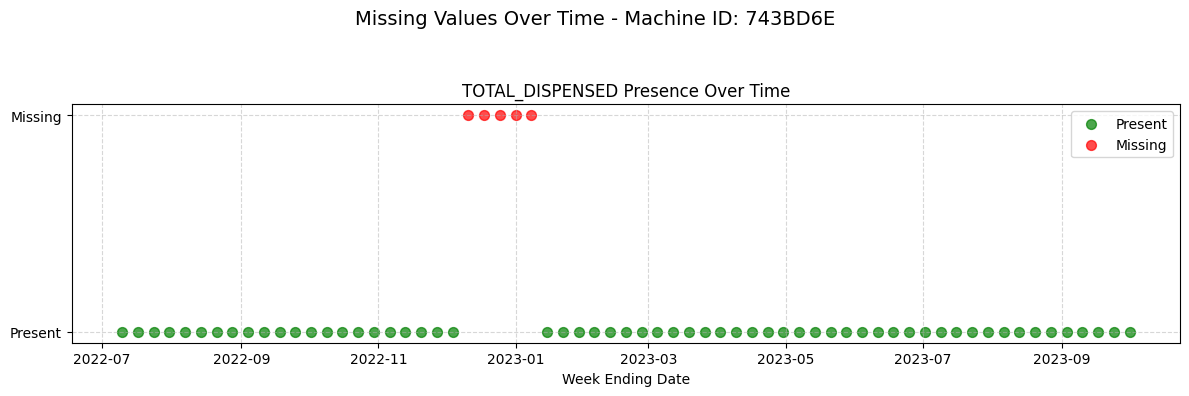


--- Machine ID: 1CD19D3 ---
Records: 65
Date Range: 2022-07-10 to 2023-10-01
Missing values in TOTAL_DISPENSED: 34


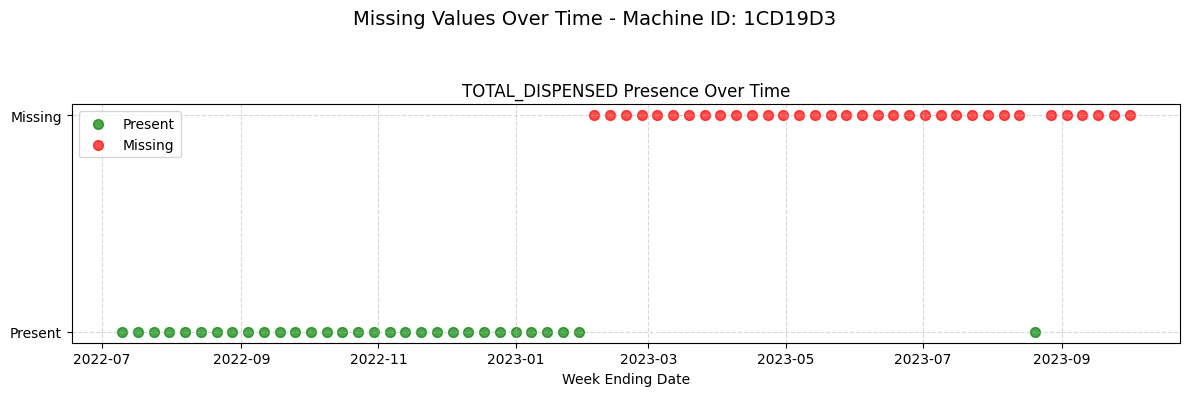


--- Machine ID: D3635AD ---
Records: 65
Date Range: 2022-07-10 to 2023-10-01
Missing values in TOTAL_DISPENSED: 0


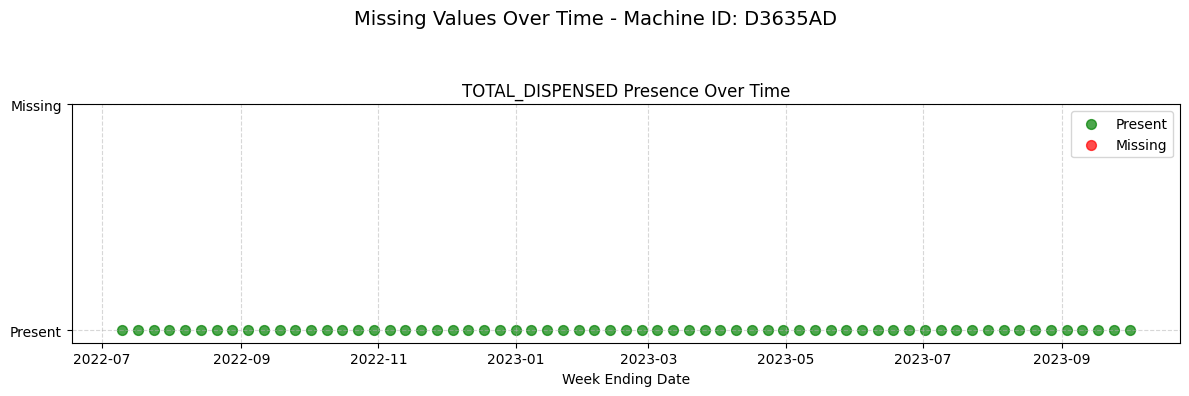


--- Machine ID: A74A256 ---
Records: 65
Date Range: 2022-07-10 to 2023-10-01
Missing values in TOTAL_DISPENSED: 4


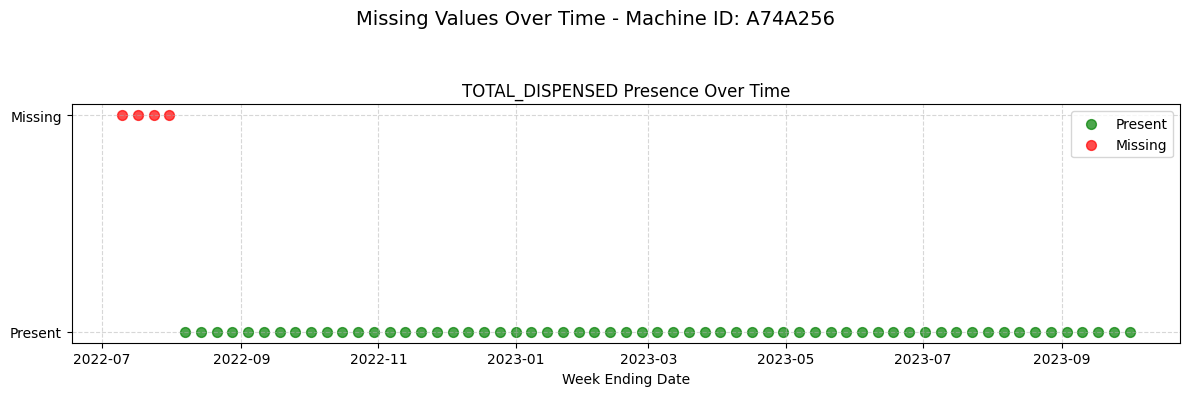


--- Machine ID: BB7EA2A ---
Records: 65
Date Range: 2022-07-10 to 2023-10-01
Missing values in TOTAL_DISPENSED: 0


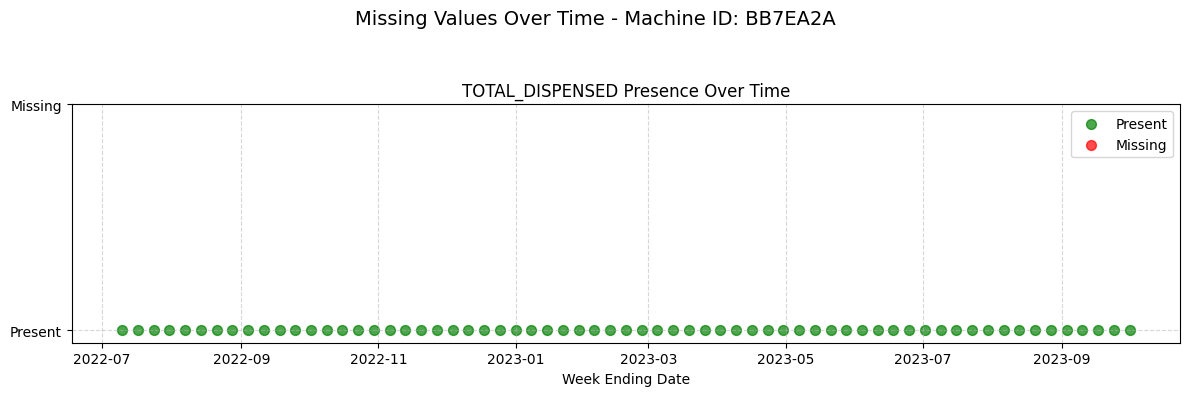


--- Machine ID: FBCE7D2 ---
Records: 30
Date Range: 2023-03-12 to 2023-10-01
Missing values in TOTAL_DISPENSED: 0


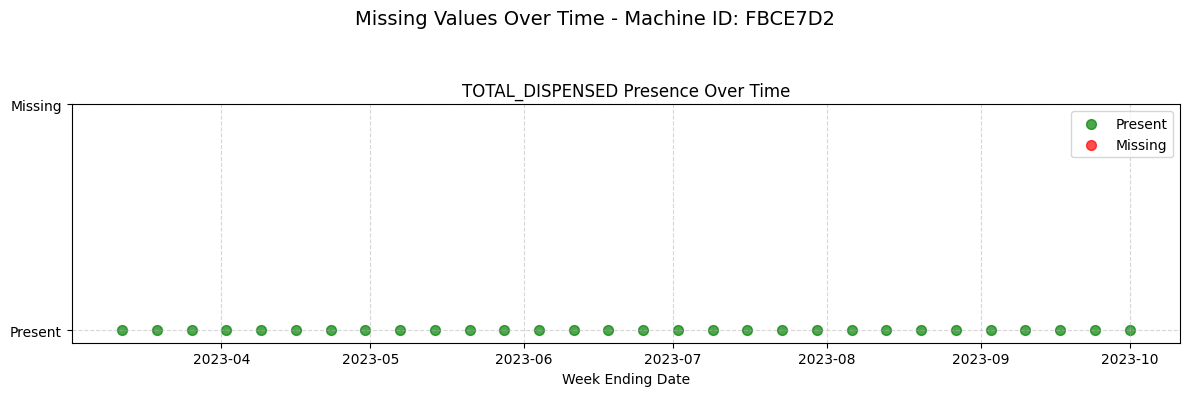

In [8]:
# Set plot style
plt.style.use('seaborn-v0_8-colorblind')

# Loop through IDs, store data, and plot summary
for id_value in unique_ids:
    # Filter data for this ID
    machine_data = data[data['ID'] == id_value].copy()
    # Convert dates to datetime
    machine_data['WEEK_END_DT'] = pd.to_datetime(machine_data['WEEK_END_DT'])
    id_dataframes[id_value] = machine_data

    # Grab total dispensed and dates
    total_dispensed = machine_data['TOTAL_DISPENSED']
    datetime_range = machine_data['WEEK_END_DT']

    # Print summary
    print(f"\n--- Machine ID: {id_value} ---")
    print(f"Records: {len(machine_data)}")
    print(f"Date Range: {datetime_range.min().date()} to {datetime_range.max().date()}")
    print(f"Missing values in TOTAL_DISPENSED: {total_dispensed.isna().sum()}")

    # --- Plot: Missing Values Timeline ---
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 4))
    fig.suptitle(f"Missing Values Over Time - Machine ID: {id_value}", fontsize=14)

    # Mask for missing values
    missing_mask = total_dispensed.isna()

    # Plot present and missing points
    ax.scatter(machine_data['WEEK_END_DT'][~missing_mask], [0]*sum(~missing_mask),
               color='green', label='Present', alpha=0.7, s=50)
    ax.scatter(machine_data['WEEK_END_DT'][missing_mask], [1]*sum(missing_mask),
               color='red', label='Missing', alpha=0.7, s=50)

    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Present', 'Missing'])
    ax.set_xlabel("Week Ending Date")
    ax.set_title("TOTAL_DISPENSED Presence Over Time")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='best')
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

In [9]:
# List to track machine IDs with ≤ 10% missing values (forward filled)
machines_filled = []

# Process each machine ID
for id_value in unique_ids:
    machine_data = data[data['ID'] == id_value].copy()
    machine_data['WEEK_END_DT'] = pd.to_datetime(machine_data['WEEK_END_DT'])

    # Calculate missing value ratio
    total_records = len(machine_data)
    null_count = machine_data['TOTAL_DISPENSED'].isna().sum()
    null_ratio = null_count / total_records

    # Forward fill if missing ≤ 10%
    if null_ratio <= 0.10:
        machine_data['TOTAL_DISPENSED'] = machine_data['TOTAL_DISPENSED'].ffill()
        machines_filled.append(id_value)

    # Store updated data
    id_dataframes[id_value] = machine_data

print("Machines with ≤ 10% missing data (forward filled):")
print(machines_filled)

Machines with ≤ 10% missing data (forward filled):
['743BD6E', 'D3635AD', 'A74A256', 'BB7EA2A', 'FBCE7D2']


##### Why Forward Filling or Backward Filling?

Forward filling or Backward Filling helps maintain consistent transitions without introducing abrupt changes. Other methods like mean imputation or interpolation might introduce artificial spikes or smoothing effects, which may not be realistic for the operational behavior of the machine.

#### Handling Outliers

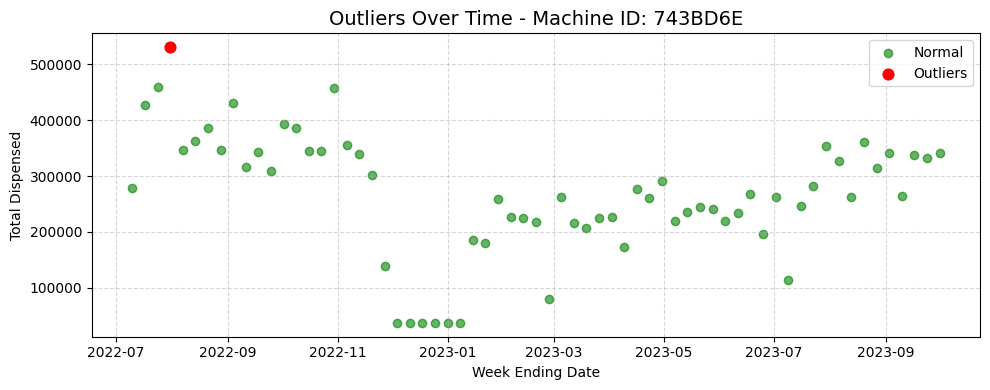

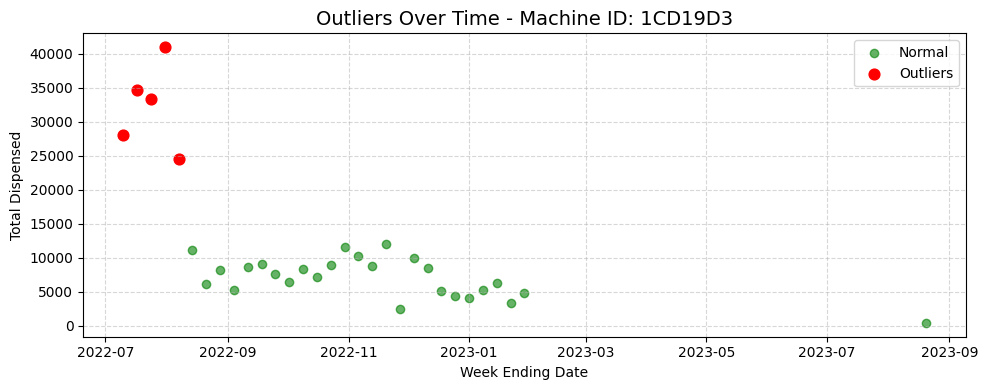

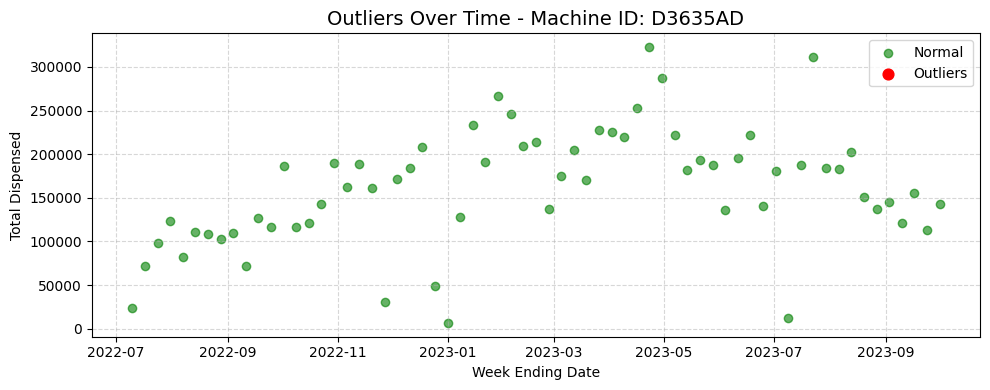

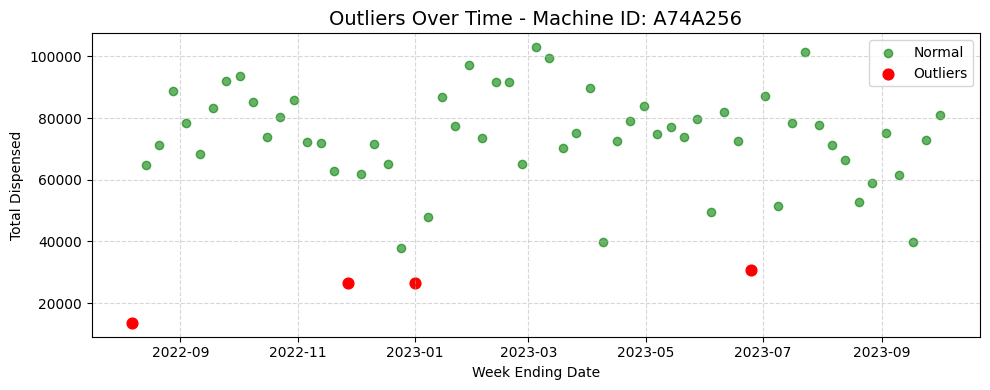

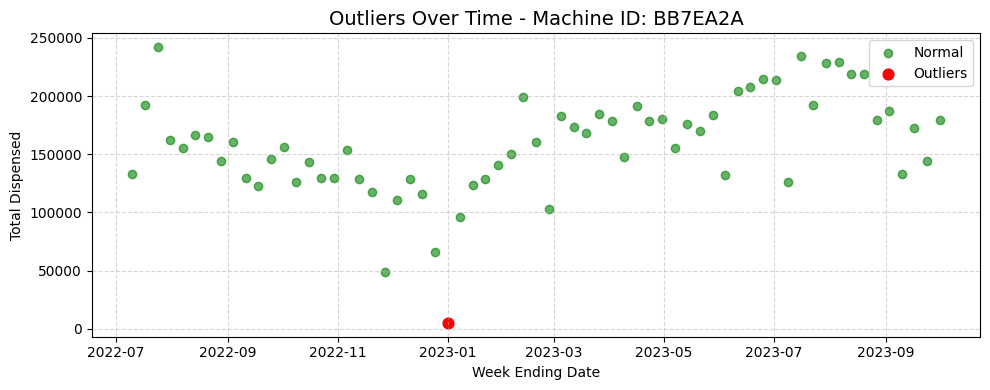

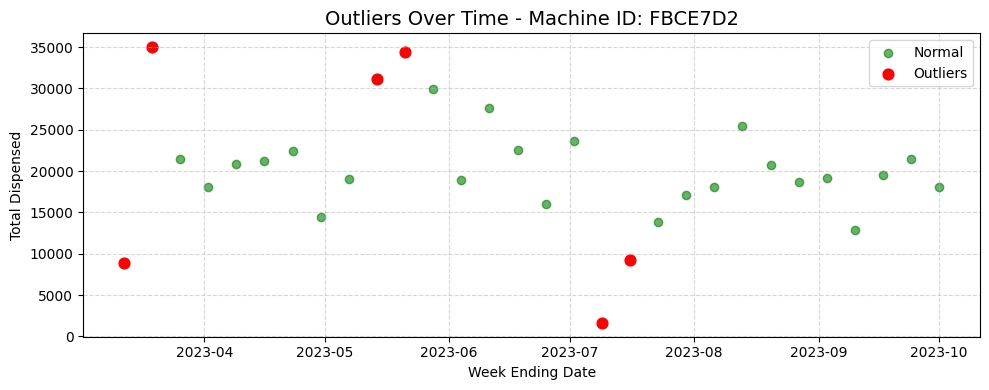

Machine 743BD6E: 1 outliers capped
Machine 1CD19D3: 5 outliers capped
Machine D3635AD: 0 outliers capped
Machine A74A256: 4 outliers capped
Machine BB7EA2A: 1 outliers capped
Machine FBCE7D2: 6 outliers capped


In [10]:
outlier_summary = {}

for id_value in unique_ids:
    machine_data = id_dataframes[id_value]

    dispensed = machine_data['TOTAL_DISPENSED']

    Q1 = machine_data['TOTAL_DISPENSED'].quantile(0.25)
    Q3 = machine_data['TOTAL_DISPENSED'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Plot the outliers
    outlier_mask = (machine_data['TOTAL_DISPENSED'] < lower_bound) | (machine_data['TOTAL_DISPENSED'] > upper_bound)

    plt.figure(figsize=(10, 4))
    plt.scatter(machine_data['WEEK_END_DT'], machine_data['TOTAL_DISPENSED'], 
                label='Normal', alpha=0.6, color='green')
    plt.scatter(machine_data['WEEK_END_DT'][outlier_mask], machine_data['TOTAL_DISPENSED'][outlier_mask], 
                label='Outliers', color='red', s=60)
    plt.title(f"Outliers Over Time - Machine ID: {id_value}", fontsize=14)
    plt.xlabel("Week Ending Date")
    plt.ylabel("Total Dispensed")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --------------------------- #

    # Cap outliers to bounds
    machine_data['TOTAL_DISPENSED'] = dispensed.clip(lower=lower_bound, upper=upper_bound)

    # Store result
    id_dataframes[id_value] = machine_data
    outlier_summary[id_value] = outlier_mask.sum()

for machine_id, count in outlier_summary.items():
    print(f"Machine {machine_id}: {count} outliers capped")

##### Why Cap Instead of Remove?

- Dropping rows breaks the sequence of weekly data.

- Capping prevents extreme values from tilting trends while keeping records intact.

## Data Visualization

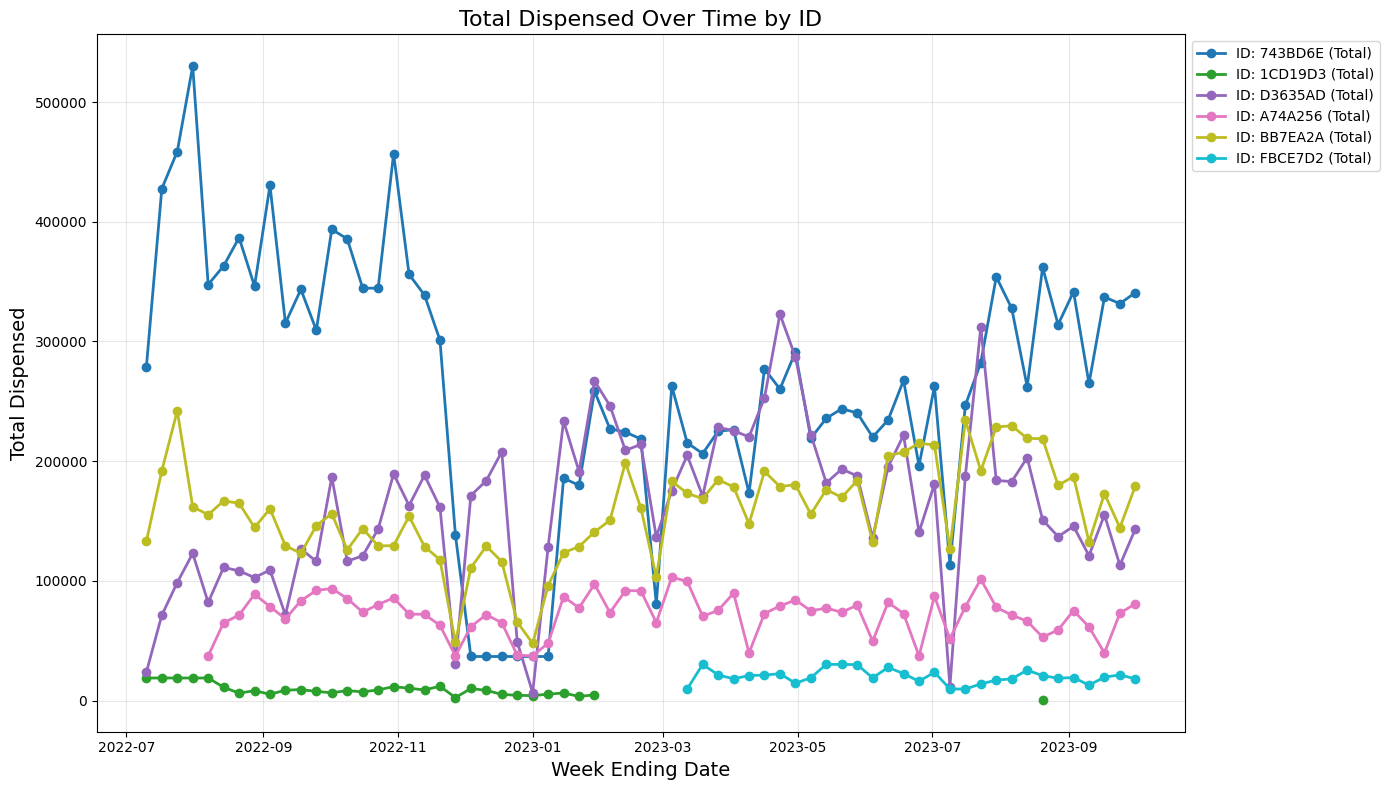

In [11]:
plt.figure(figsize=(14, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_ids)))

# Plot TOTAL_DISPENSED for each ID
for i, id_value in enumerate(unique_ids):
    id_data = id_dataframes[id_value]  
    if not id_data['TOTAL_DISPENSED'].isna().all(): 
        plt.plot(id_data['WEEK_END_DT'], id_data['TOTAL_DISPENSED'], 
                 marker='o', linestyle='-', linewidth=2, color=colors[i],
                 label=f'ID: {id_value} (Total)')

plt.title('Total Dispensed Over Time by ID', fontsize=16)
plt.xlabel('Week Ending Date', fontsize=14)
plt.ylabel('Total Dispensed', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

## Feature Engineering and Model Selection

### Key Assumptions

Temporal Patterns

- Historical patterns (trends, cycles) (Till June) will persist into the forecast period (July–November 2023).

- Stationarity: ARIMA assumes the time series becomes stationary after differencing (order d=2).

Model-Specific Assumptions

- ARIMA: Linear relationships between past values and future trends (via order=(1,2,1)).

- Regression Models (LR/RF/XGBoost): Lagged features sufficiently capture temporal dependencies.

Data Quality

- Machines with sufficient training data (>20 weeks) are representative of future behavior.

- Missing values (if any) were handled prior to modeling (assumes no gaps in TOTAL_DISPENSED after preprocessing).

Operational Context

- No external disruptions occur during the forecast period.

Independence

- Machines are treated as independent entities (no cross-machine dependencies modeled).

### ARIMA Model

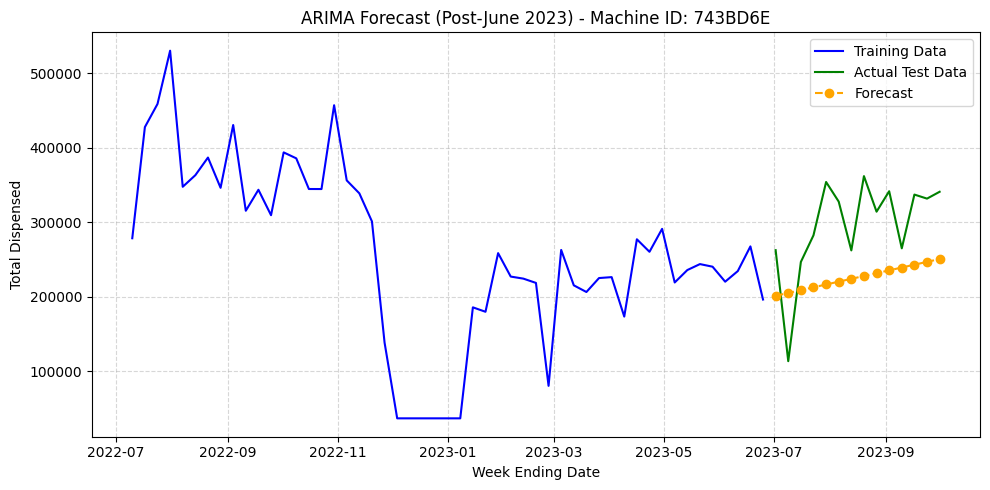

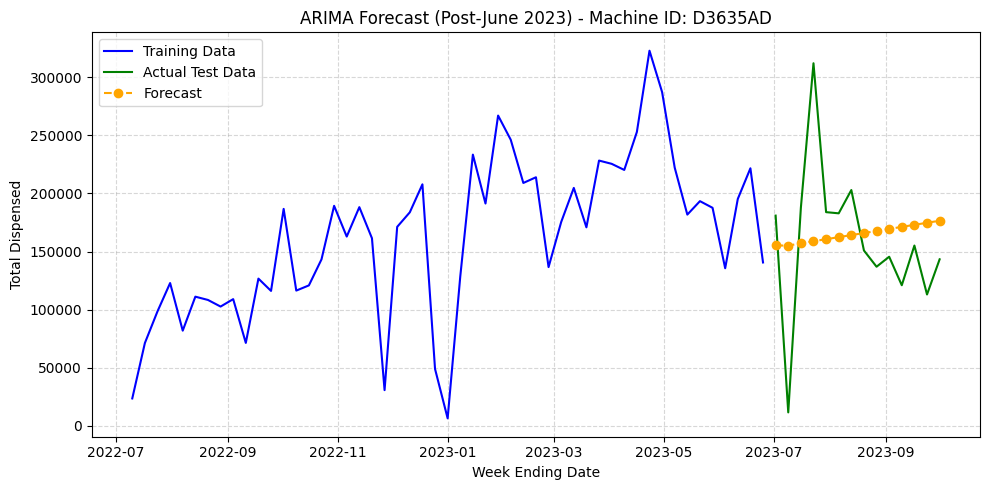

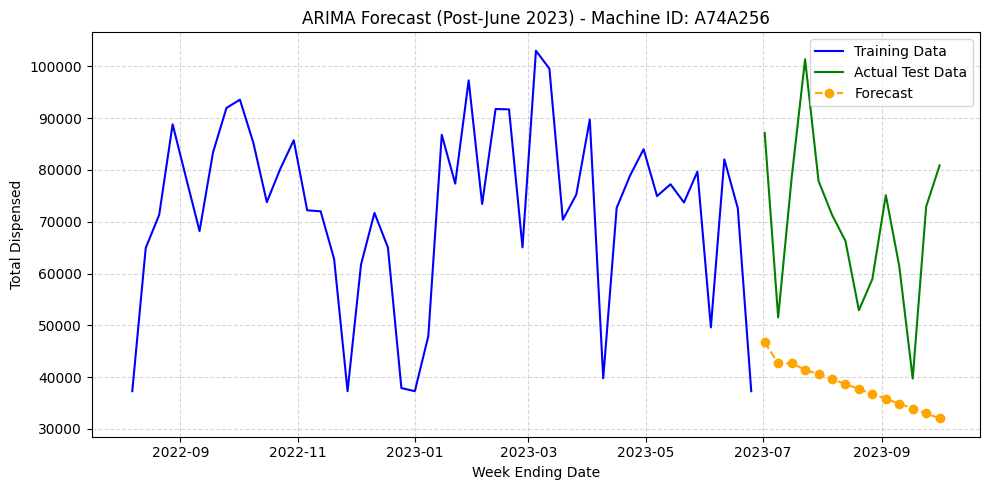

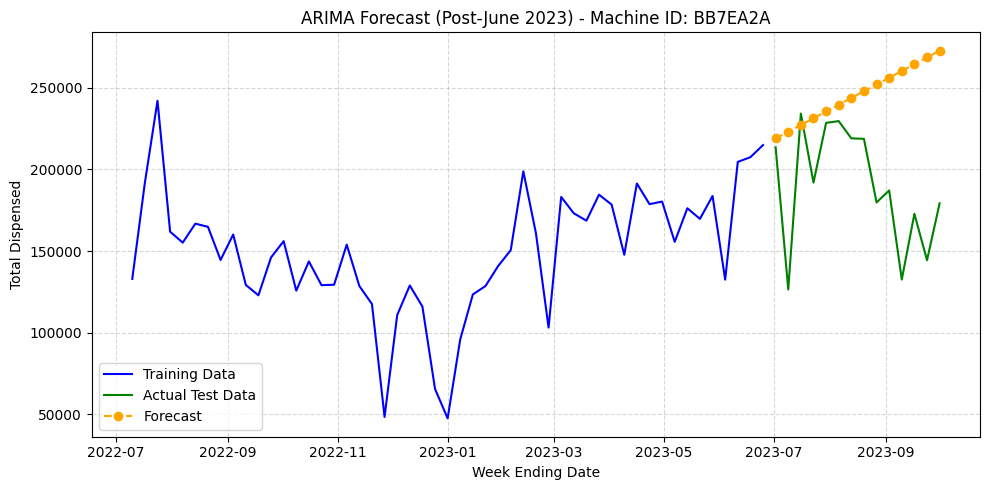

Skipping ID FBCE7D2: Insufficient training data.


In [12]:
from statsmodels.tsa.arima.model import ARIMA

cutoff_date = pd.to_datetime("2023-06-30")

forecast_results_arima = {}  
fitted_models_arima = {} 

# Iterate through machines
for id_value in machines_filled:
    machine_data = id_dataframes[id_value]
    machine_data = machine_data.sort_values('WEEK_END_DT')

    ts_full = machine_data[['WEEK_END_DT', 'TOTAL_DISPENSED']].set_index('WEEK_END_DT')
    ts_train = ts_full[ts_full.index <= cutoff_date]
    ts_test = ts_full[ts_full.index > cutoff_date]

    # Skip machines with insufficient training data
    if len(ts_train) < 20:
        print(f"Skipping ID {id_value}: Insufficient training data.")
        continue

    try:
        # Fit ARIMA model
        model = ARIMA(ts_train['TOTAL_DISPENSED'], order=(1, 2, 1))
        model_fit = model.fit()

        # Forecast the next values
        forecast = model_fit.forecast(steps=len(ts_test))
        forecast.index = ts_test.index[:len(forecast)]

        # Store forecasted values
        forecast_results_arima[id_value] = forecast
        fitted_models_arima[id_value] = model_fit

        # Plot the results
        plt.figure(figsize=(10, 5))
        plt.plot(ts_train.index, ts_train['TOTAL_DISPENSED'], label='Training Data', color='blue')
        plt.plot(ts_test.index, ts_test['TOTAL_DISPENSED'], label='Actual Test Data', color='green')
        plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--', marker='o')
        plt.title(f"ARIMA Forecast (Post-June 2023) - Machine ID: {id_value}")
        plt.xlabel("Week Ending Date")
        plt.ylabel("Total Dispensed")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"ARIMA failed for ID {id_value}: {e}")

### Linear Regression Model: Baseline Model

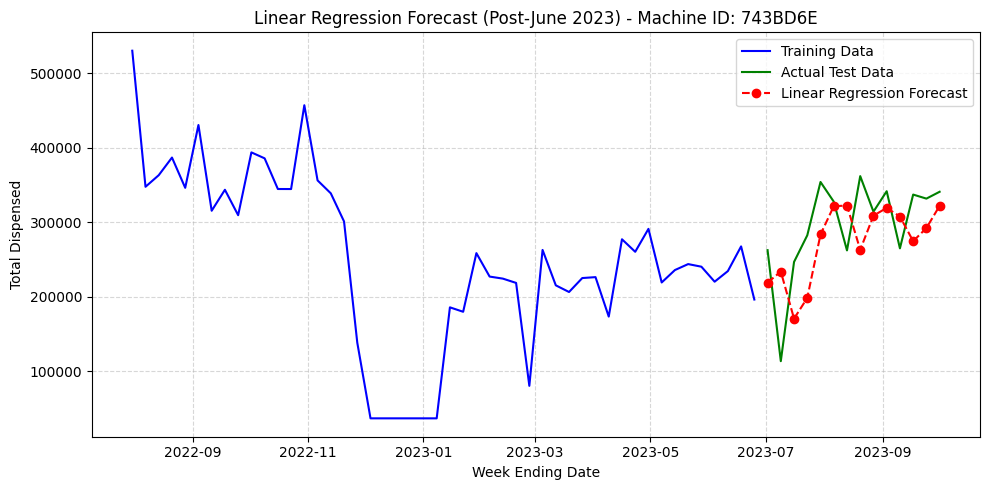

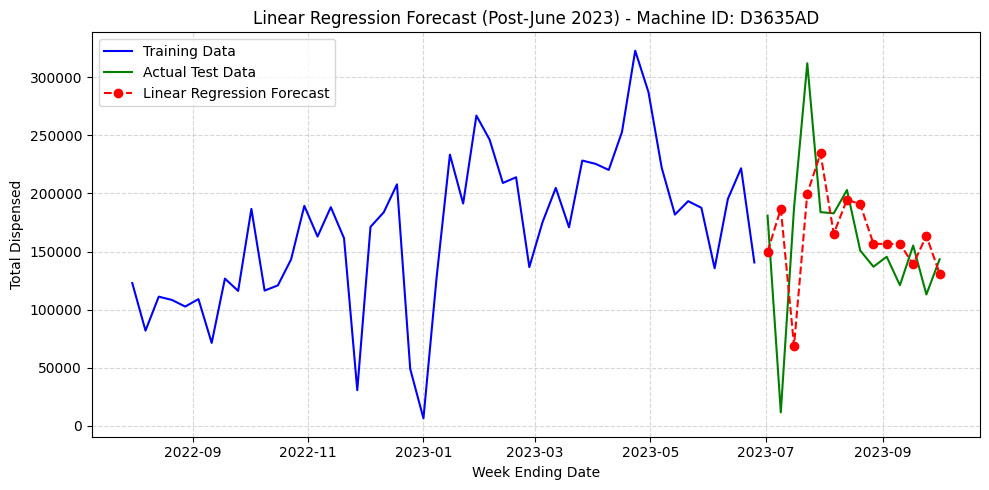

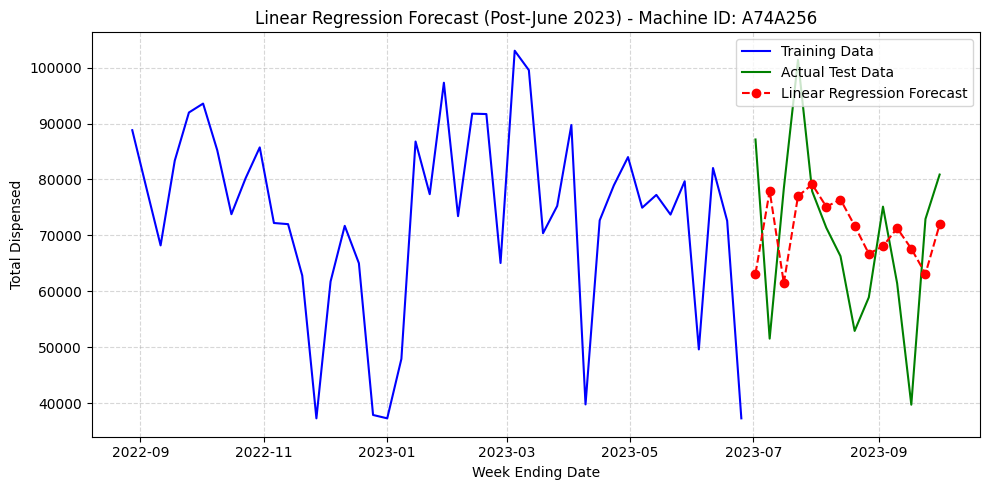

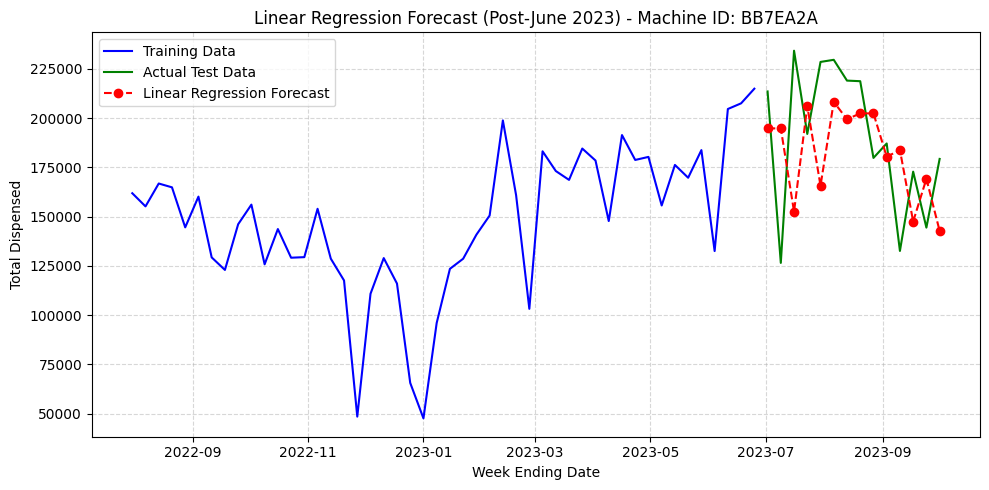

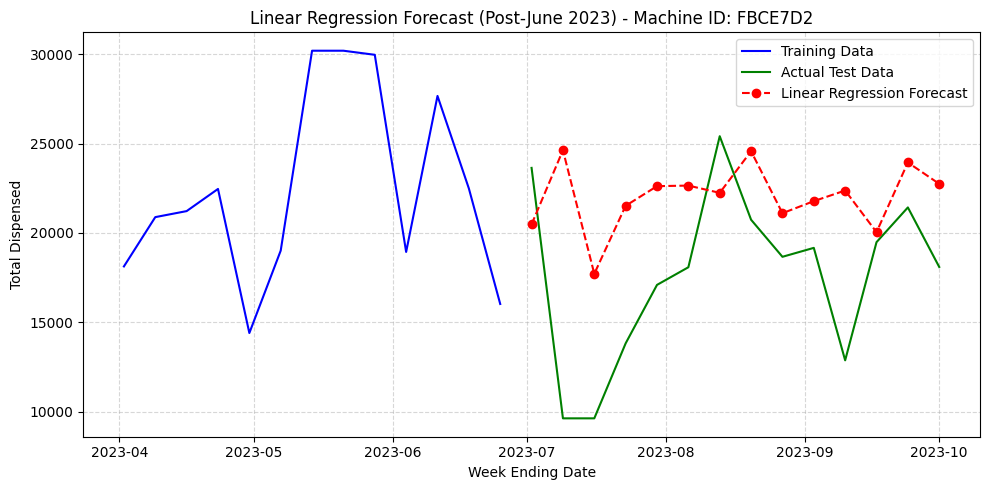

In [13]:
from sklearn.linear_model import LinearRegression

# Parameters
cutoff_date = pd.to_datetime("2023-06-30")
forecast_horizon = 10  
n_lags = 3

forecast_results_lr = {}  
fitted_models_lr = {}     

# Feature Engineering
def create_lag_features(series, n_lags):
    df = pd.DataFrame(series)
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['TOTAL_DISPENSED'].shift(lag)
    df = df.dropna()
    return df

# Iterate through machines
for id_value in machines_filled:
    machine_data = id_dataframes[id_value].copy()
    machine_data = machine_data.sort_values('WEEK_END_DT')

    ts_full = machine_data[['WEEK_END_DT', 'TOTAL_DISPENSED']]

    if len(ts_full) < (n_lags + forecast_horizon + 5):
        print(f"Skipping ID {id_value}: Insufficient data.")
        continue

    # Create lag features
    df_lagged = create_lag_features(ts_full.set_index('WEEK_END_DT')['TOTAL_DISPENSED'], n_lags)
    df_lagged['date'] = df_lagged.index
    df_lagged = df_lagged.sort_values('date')

    # Split into train/test
    train_df = df_lagged[df_lagged['date'] <= cutoff_date]
    test_df = df_lagged[df_lagged['date'] > cutoff_date]

    X_train = train_df[[f'lag_{i}' for i in range(1, n_lags+1)]]
    y_train = train_df['TOTAL_DISPENSED']
    X_test = test_df[[f'lag_{i}' for i in range(1, n_lags+1)]]
    y_test = test_df['TOTAL_DISPENSED']

    try:
        # Train Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Forecast
        y_pred = model.predict(X_test)

        # Store forecasted values
        forecast_results_lr[id_value] = y_pred
        fitted_models_lr[id_value] = model

        # Plot forecast for visualization
        plt.figure(figsize=(10, 5))
        plt.plot(train_df['date'], y_train, label='Training Data', color='blue')
        plt.plot(test_df['date'], y_test, label='Actual Test Data', color='green')
        plt.plot(test_df['date'], y_pred, label='Linear Regression Forecast', color='red', linestyle='--', marker='o')
        plt.title(f"Linear Regression Forecast (Post-June 2023) - Machine ID: {id_value}")
        plt.xlabel("Week Ending Date")
        plt.ylabel("Total Dispensed")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Linear Regression failed for ID {id_value}: {e}")

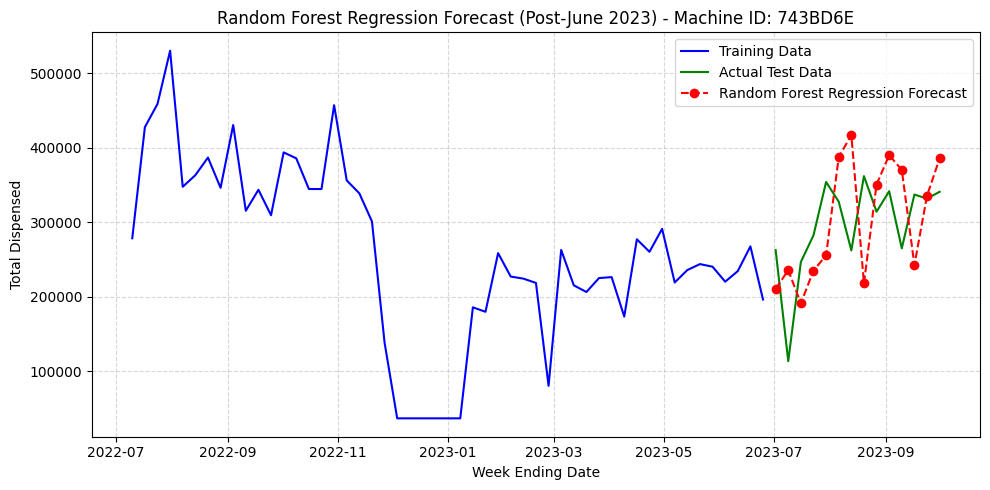

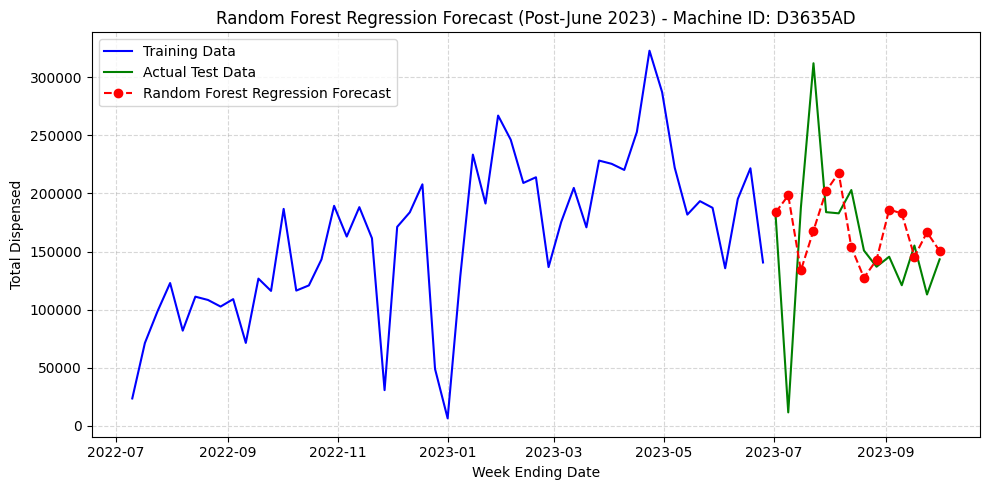

Random Forest Regression failed for ID A74A256: Input y contains NaN.


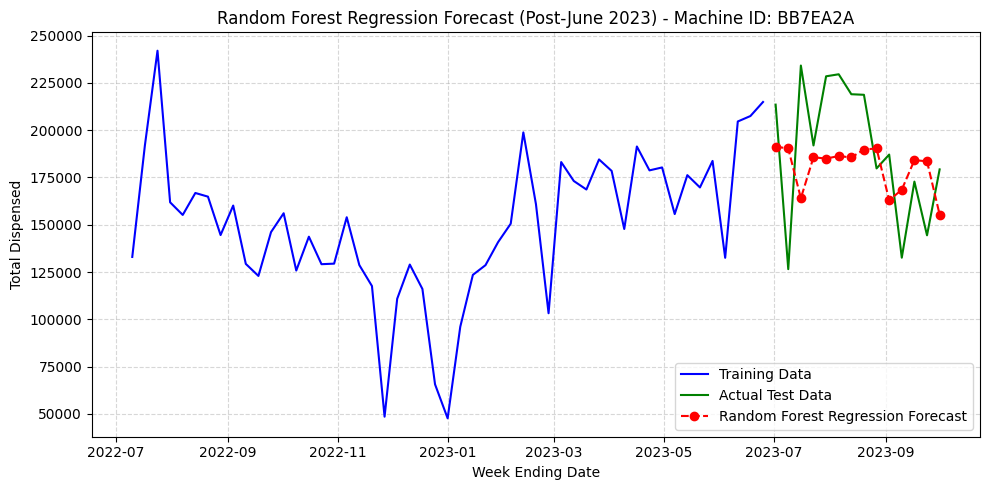

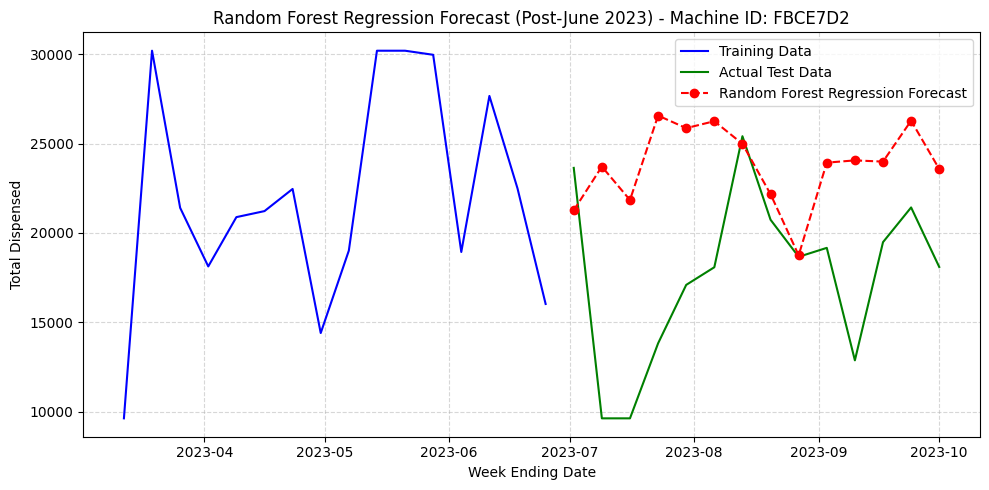

In [14]:
from sklearn.ensemble import RandomForestRegressor

cutoff_date = pd.to_datetime("2023-06-30")
forecast_horizon = 10  
n_lags = 3

forecast_results_rf = {} 
fitted_models_rf = {}     

def create_lag_features(series, n_lags):
    df = pd.DataFrame(series)
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['TOTAL_DISPENSED'].shift(lag)
    return df

# Iterate through machines
for id_value in machines_filled:
    machine_data = id_dataframes[id_value].copy()
    machine_data = machine_data.sort_values('WEEK_END_DT')

    ts_full = machine_data[['WEEK_END_DT', 'TOTAL_DISPENSED']]

    if len(ts_full) < (n_lags + forecast_horizon + 5):
        print(f"Skipping ID {id_value}: Insufficient data.")
        continue

    # Create lag features
    df_lagged = create_lag_features(ts_full.set_index('WEEK_END_DT')['TOTAL_DISPENSED'], n_lags)
    df_lagged['date'] = df_lagged.index
    df_lagged = df_lagged.sort_values('date')

    # Split into train/test
    train_df = df_lagged[df_lagged['date'] <= cutoff_date]
    test_df = df_lagged[df_lagged['date'] > cutoff_date]

    X_train = train_df[[f'lag_{i}' for i in range(1, n_lags+1)]]
    y_train = train_df['TOTAL_DISPENSED']
    X_test = test_df[[f'lag_{i}' for i in range(1, n_lags+1)]]
    y_test = test_df['TOTAL_DISPENSED']

    try:
        # Train Random Forest Regressor model
        model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
        model_rf.fit(X_train, y_train)

        # Predict
        y_pred = model_rf.predict(X_test)

        # Store forecasted values
        forecast_results_rf[id_value] = y_pred
        fitted_models_rf[id_value] = model_rf

        # Plot forecast for visualization
        plt.figure(figsize=(10, 5))
        plt.plot(train_df['date'], y_train, label='Training Data', color='blue')
        plt.plot(test_df['date'], y_test, label='Actual Test Data', color='green')
        plt.plot(test_df['date'], y_pred, label='Random Forest Regression Forecast', color='red', linestyle='--', marker='o')
        plt.title(f"Random Forest Regression Forecast (Post-June 2023) - Machine ID: {id_value}")
        plt.xlabel("Week Ending Date")
        plt.ylabel("Total Dispensed")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Random Forest Regression failed for ID {id_value}: {e}")

### XGBoost with Cross Validation

Best hyperparameters for Machine ID 743BD6E: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}


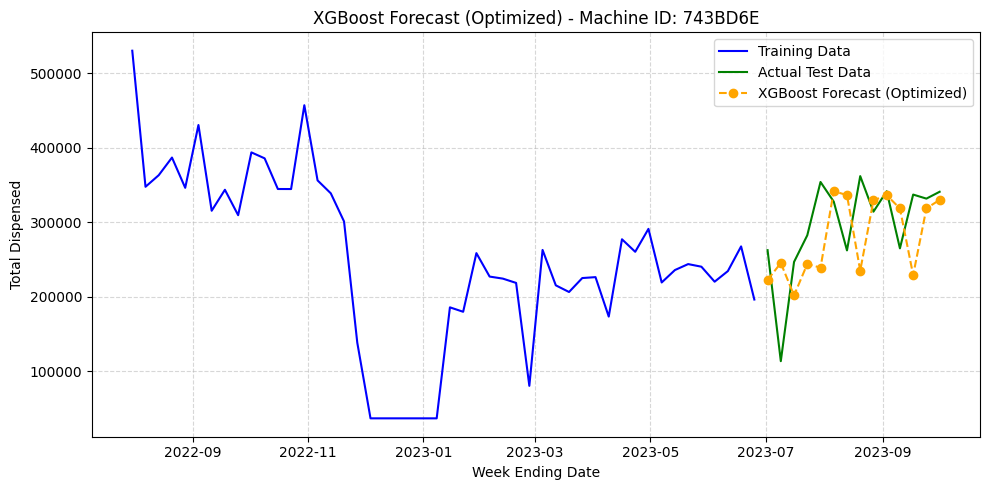

Best hyperparameters for Machine ID D3635AD: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9}


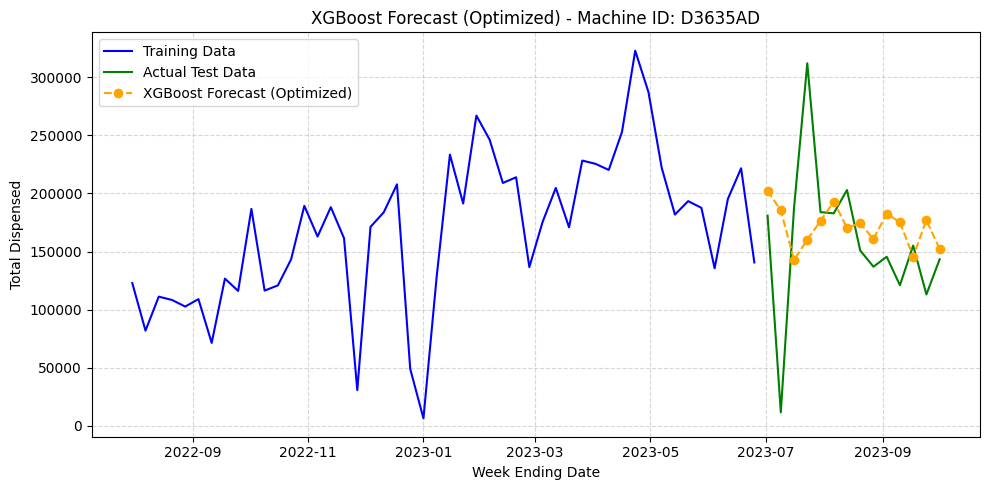

Best hyperparameters for Machine ID A74A256: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


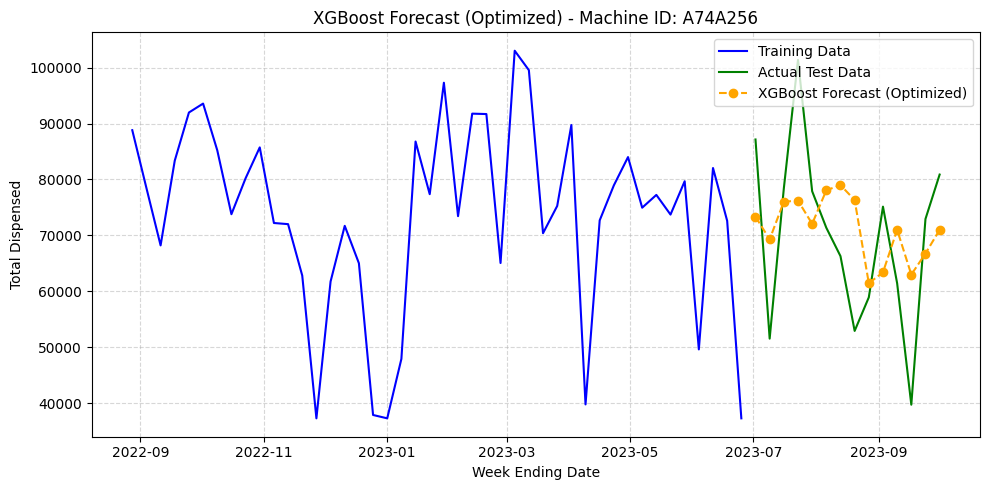

Best hyperparameters for Machine ID BB7EA2A: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}


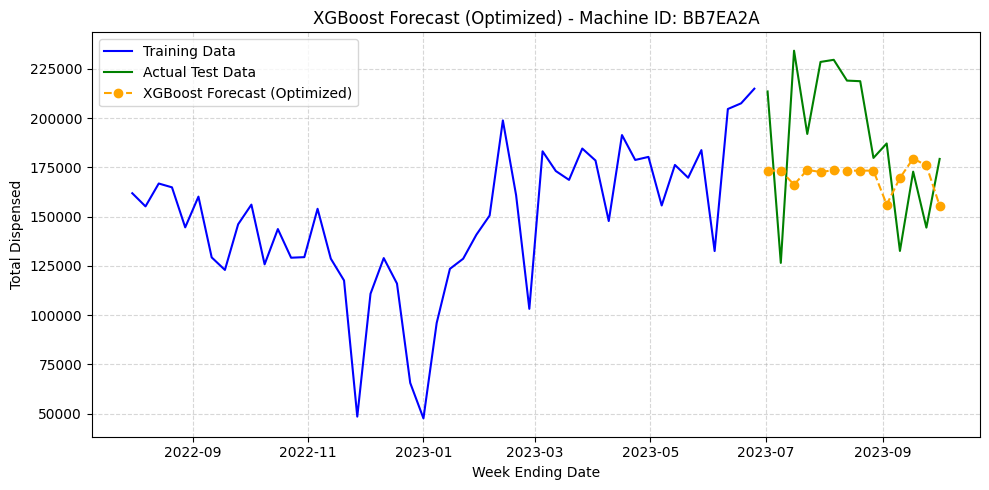

Best hyperparameters for Machine ID FBCE7D2: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}


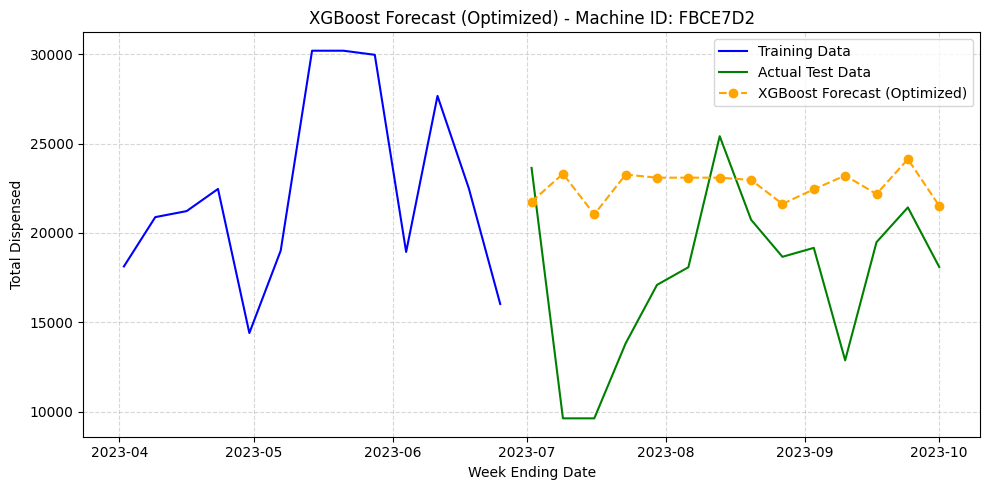

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

cutoff_date = pd.to_datetime("2023-06-30")
forecast_horizon = 10  
n_lags = 3

forecast_results_xgboost_cv = {}
fitted_models_xgboost_cv = {}  

# Feature Engineering
def create_lag_features(series, n_lags):
    df = pd.DataFrame(series)
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['TOTAL_DISPENSED'].shift(lag)
    df = df.dropna()
    return df

for id_value in machines_filled:
    machine_data = id_dataframes[id_value].copy()
    machine_data = machine_data.sort_values('WEEK_END_DT')

    ts_full = machine_data[['WEEK_END_DT', 'TOTAL_DISPENSED']]

    if len(ts_full) < (n_lags + forecast_horizon + 5):
        print(f"Skipping ID {id_value}: Insufficient data for model training.")
        continue

    # Create lag features
    df_lagged = create_lag_features(ts_full.set_index('WEEK_END_DT')['TOTAL_DISPENSED'], n_lags)
    df_lagged['date'] = df_lagged.index
    df_lagged = df_lagged.sort_values('date')

    # Split into train/test
    train_df = df_lagged[df_lagged['date'] <= cutoff_date]
    test_df = df_lagged[df_lagged['date'] > cutoff_date]

    X_train = train_df[[f'lag_{i}' for i in range(1, n_lags+1)]]
    y_train = train_df['TOTAL_DISPENSED']
    X_test = test_df[[f'lag_{i}' for i in range(1, n_lags+1)]]
    y_test = test_df['TOTAL_DISPENSED']

    try:
        # Hyperparameter grid to search
        param_grid = {
            'n_estimators': [100, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.8, 0.9]
        }

        # TimeSeriesSplit for cross-validation
        tscv = TimeSeriesSplit(n_splits=5)  

        # Perform GridSearchCV
        grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42),
                                   param_grid=param_grid,
                                   scoring='neg_mean_squared_error',
                                   cv=tscv)

        grid_search.fit(X_train, y_train)

        # Get the best model and its predictions
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        forecast_results_xgboost_cv[id_value] = y_pred
        fitted_models_xgboost_cv[id_value] = best_model

        print(f"Best hyperparameters for Machine ID {id_value}: {grid_search.best_params_}")

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(train_df['date'], y_train, label='Training Data', color='blue')
        plt.plot(test_df['date'], y_test, label='Actual Test Data', color='green')
        plt.plot(test_df['date'], y_pred, label='XGBoost Forecast (Optimized)', color='orange', linestyle='--', marker='o')
        plt.title(f"XGBoost Forecast (Optimized) - Machine ID: {id_value}")
        plt.xlabel("Week Ending Date")
        plt.ylabel("Total Dispensed")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"XGBoost failed for ID {id_value}: {e}")

## Accuracy Checks

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

all_metrics = {}
cutoff_date = pd.to_datetime("2023-06-30")

models = {
    'ARIMA': forecast_results_arima,
    'LinearRegression': forecast_results_lr,
    'RandomForest': forecast_results_rf,
    'XGBoost_CV': forecast_results_xgboost_cv,
}

for model_name, forecast_results in models.items():
    metrics_results = {}
    for id_value, y_pred in forecast_results.items():
        ts_test = id_dataframes[id_value].set_index('WEEK_END_DT')
        ts_test = ts_test[ts_test.index > cutoff_date]
        y_true = ts_test['TOTAL_DISPENSED'][:len(y_pred)]

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if all(y_true != 0) else np.nan

        metrics_results[id_value] = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        }
    all_metrics[model_name] = metrics_results

In [17]:
print("--- Best Model Comparison ---")
best_models = {}
for machine_id in id_dataframes.keys():
    best_mae = float('inf')
    best_rmse = float('inf')
    best_mape = float('inf')
    best_model = None

    print(f"Machine {machine_id}:")
    for model_name, metrics_by_machine in all_metrics.items():
        metrics = metrics_by_machine.get(machine_id)
        if metrics:
            if metrics['MAE'] < best_mae:
                best_mae = metrics['MAE']
                best_rmse = metrics['RMSE']
                best_mape = metrics['MAPE']
                best_model = model_name
            elif metrics['MAE'] == best_mae and metrics['RMSE'] < best_rmse:
                best_rmse = metrics['RMSE']
                best_mape = metrics['MAPE']
                best_model = model_name
            elif metrics['MAE'] == best_mae and metrics['RMSE'] == best_rmse and (metrics['MAPE'] < best_mape or np.isnan(best_mape)):
                best_mape = metrics['MAPE']
                best_model = model_name

    if best_model:
        print(f"\n  Best model for Machine {machine_id}: {best_model} (MAE={best_mae:.4f}, RMSE={best_rmse:.4f}, MAPE={best_mape:.4f}%)")
        best_models[machine_id] = best_model
    else:
        print(f"\n  No valid metrics to determine the best model for Machine {machine_id}.")

print("--- Best Model per Machine ---")
for machine, model in best_models.items():
    print(f"Machine {machine}: {model}")

--- Best Model Comparison ---
Machine 743BD6E:

  Best model for Machine 743BD6E: LinearRegression (MAE=53635.3654, RMSE=63121.6328, MAPE=22.5411%)
Machine 1CD19D3:

  No valid metrics to determine the best model for Machine 1CD19D3.
Machine D3635AD:

  Best model for Machine D3635AD: XGBoost_CV (MAE=47351.2444, RMSE=69002.2184, MAPE=126.9595%)
Machine A74A256:

  Best model for Machine A74A256: XGBoost_CV (MAE=12206.2913, RMSE=14257.2474, MAPE=19.5085%)
Machine BB7EA2A:

  Best model for Machine BB7EA2A: RandomForest (MAE=32615.0731, RMSE=37283.9405, MAPE=18.0948%)
Machine FBCE7D2:

  Best model for Machine FBCE7D2: LinearRegression (MAE=5235.3692, RMSE=6362.2951, MAPE=38.4218%)
--- Best Model per Machine ---
Machine 743BD6E: LinearRegression
Machine D3635AD: XGBoost_CV
Machine A74A256: XGBoost_CV
Machine BB7EA2A: RandomForest
Machine FBCE7D2: LinearRegression


## Inference

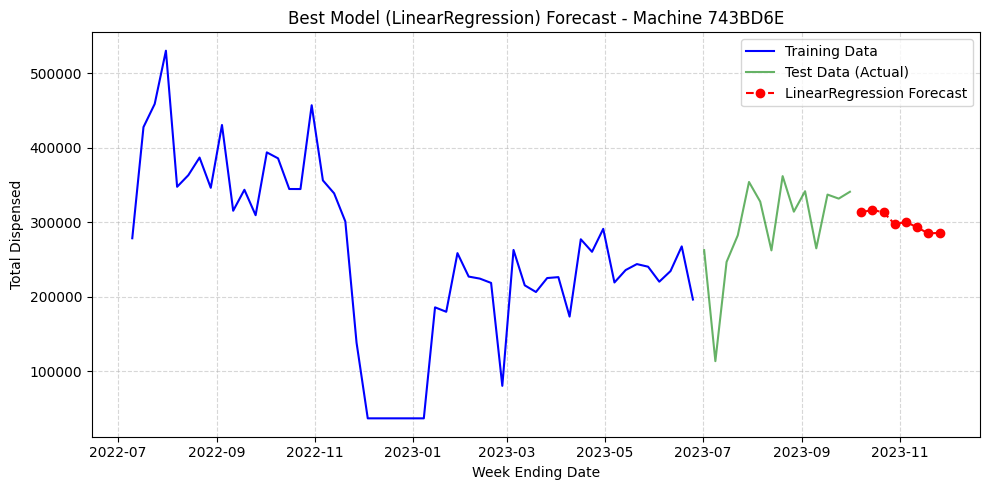

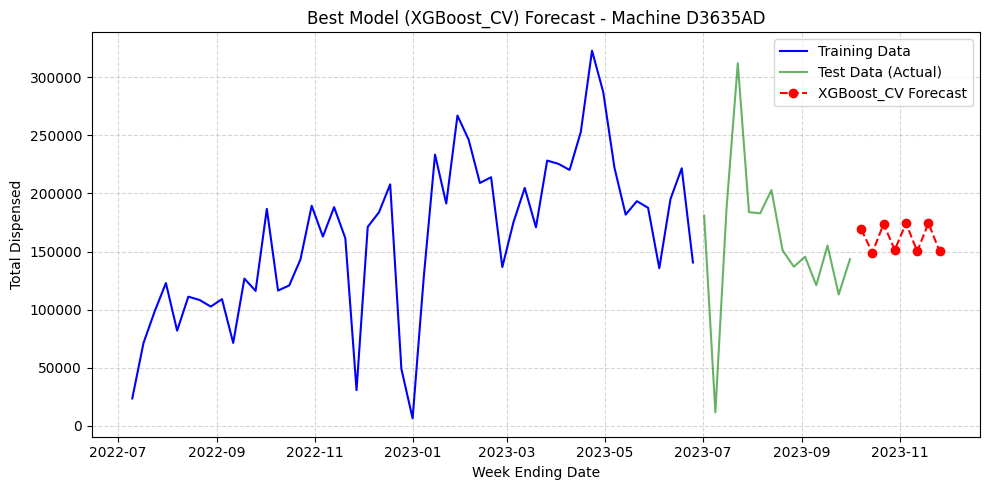

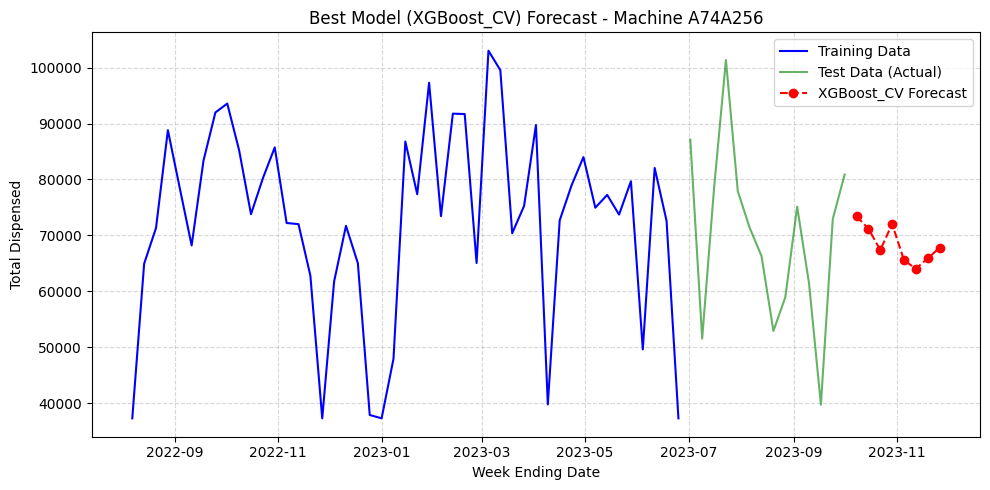

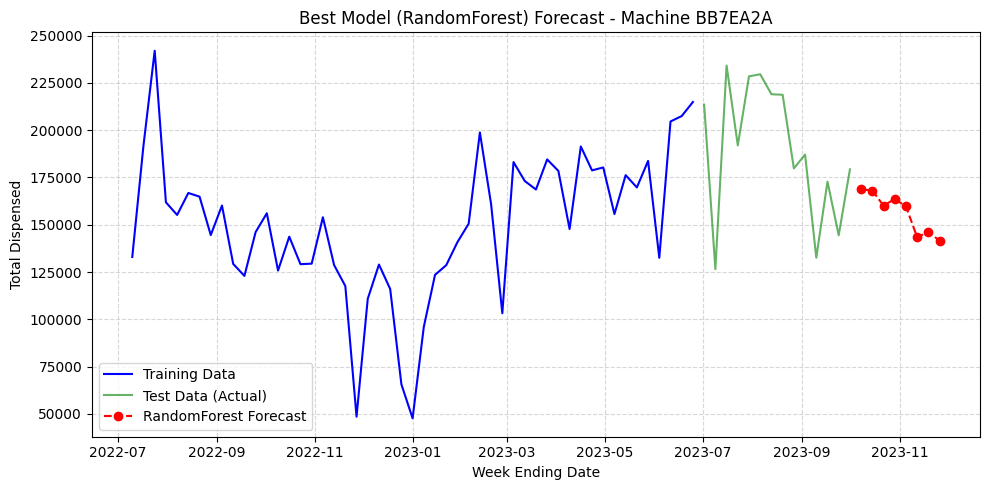

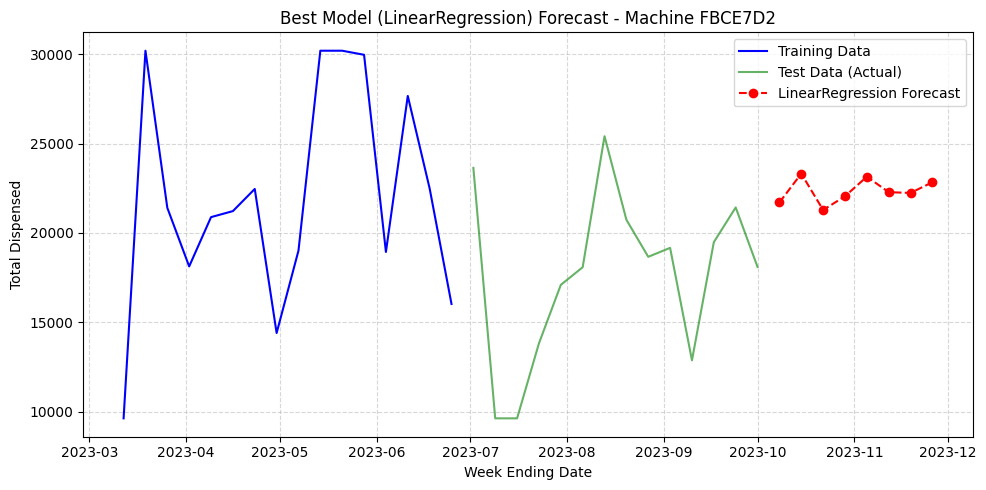

In [18]:
# Store November forecasts
november_forecasts = {}
steps_ahead = 8
forecast_start_date = pd.to_datetime("2023-10-08")
forecast_dates = pd.date_range(start=forecast_start_date, periods=steps_ahead, freq='W-SUN')
n_lags = 3

for machine_id, model_name in best_models.items():
    try:
        if machine_id not in id_dataframes:
            print(f"Skipping Machine {machine_id}: No data available.")
            continue
            
        machine_data = id_dataframes[machine_id].sort_values('WEEK_END_DT')
        ts_full = machine_data.set_index('WEEK_END_DT')['TOTAL_DISPENSED']
        
        # Extract training and test data
        ts_train = ts_full[ts_full.index <= cutoff_date]
        ts_test = ts_full[ts_full.index > cutoff_date]
        
        if model_name == 'ARIMA':
            model_fit = fitted_models_arima.get(machine_id)
            if not model_fit:
                print(f"ARIMA model not found for Machine {machine_id}.")
                continue
            
            # Forecast from the last test point
            forecast = model_fit.forecast(steps=steps_ahead)
            forecast = pd.Series(forecast, index=forecast_dates)
            
        elif model_name in ['LinearRegression', 'RandomForest', 'XGBoost_CV']:
            if model_name == 'LinearRegression':
                model = fitted_models_lr.get(machine_id)
            elif model_name == 'RandomForest':
                model = fitted_models_rf.get(machine_id)
            elif model_name == 'XGBoost_CV':
                model = fitted_models_xgboost_cv.get(machine_id)
            
            if not model:
                print(f"{model_name} model not found for Machine {machine_id}.")
                continue
            
            if len(ts_test) < n_lags:
                print(f"Insufficient test data for Machine {machine_id}.")
                continue
            
            last_lags = ts_test.values[-n_lags:].tolist() 
            
            # Generate forecasts iteratively
            forecasts = []
            for _ in range(steps_ahead):
                X = np.array(last_lags).reshape(1, -1)
                pred = model.predict(X)[0]
                forecasts.append(pred)
                # Update lags for next prediction
                last_lags = last_lags[1:] + [pred] if len(last_lags) > 1 else [pred]
            
            forecast = pd.Series(forecasts, index=forecast_dates)
            
        else:
            print(f"Unsupported model {model_name} for Machine {machine_id}.")
            continue
        
        november_forecasts[machine_id] = forecast
        
        # Plot results
        plt.figure(figsize=(10, 5))
        plt.plot(ts_train.index, ts_train, label='Training Data', color='blue')
        plt.plot(ts_test.index, ts_test, label='Test Data (Actual)', color='green', alpha=0.6)
        plt.plot(forecast.index, forecast, label=f'{model_name} Forecast', 
                 linestyle='--', marker='o', color='red')
        plt.title(f"Best Model ({model_name}) Forecast - Machine {machine_id}")
        plt.xlabel("Week Ending Date")
        plt.ylabel("Total Dispensed")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error forecasting for Machine {machine_id} ({model_name}): {str(e)}")

## Next Steps

* **Cyclical Temporal Features:** Encode day of week and week of year using sine/cosine to capture seasonality.
* **Rolling Stats:** Include rolling mean, std, min, max for past weeks to capture trends/volatility.
* **Advanced Time Series Models:** Experiment with other time series models(Prophet, SARIMA).
* **Auto Arima:** Use autoarima to get perfect pdq values.
* **Hyperparameter Tuning:** Apply CV to all models (not just XGBoost).
* **Flavored Water Forecasting:** Apply the same pipeline to flavor dispense data.
* **Use External Data:** Bring in weather or event data for added context.
* **Deep Learning:** Use LSTM with more time series data.